<a href="https://colab.research.google.com/github/shahnbej/Data_Science/blob/main/stock_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance torch numpy pandas matplotlib seaborn sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


[*********************100%***********************]  1 of 1 completed

Using device: cpu


Epoch [10/100], Loss: 0.0267
Epoch [20/100], Loss: 0.0097
Epoch [30/100], Loss: 0.0087
Epoch [40/100], Loss: 0.0084
Epoch [50/100], Loss: 0.0074
Epoch [60/100], Loss: 0.0068
Epoch [70/100], Loss: 0.0060
Epoch [80/100], Loss: 0.0050
Epoch [90/100], Loss: 0.0035
Epoch [100/100], Loss: 0.0010
Test Loss (MSE): 0.2390
RMSE: 84.62
MAE: 82.93
Direction Accuracy: 0.51

Simulating real-time predictions (first 5 for brevity):
Day 1 - Predicted: 92.16, Actual: 83.46
Day 2 - Predicted: 93.42, Actual: 85.67
Day 3 - Predicted: 94.88, Actual: 85.55
Day 4 - Predicted: 96.32, Actual: 85.59
Day 5 - Predicted: 97.76, Actual: 85.10


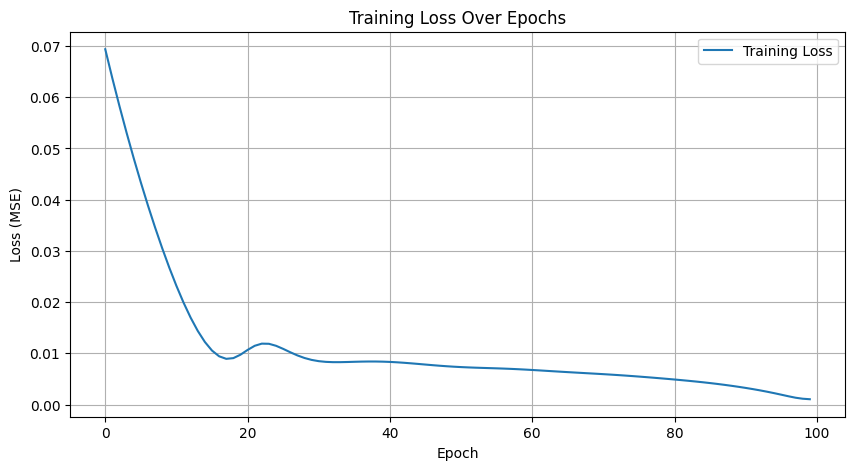

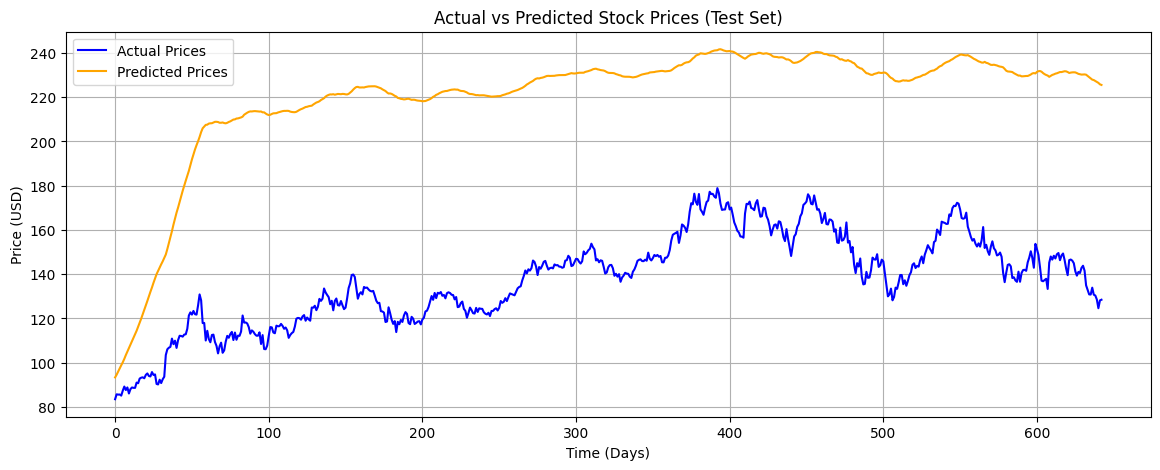

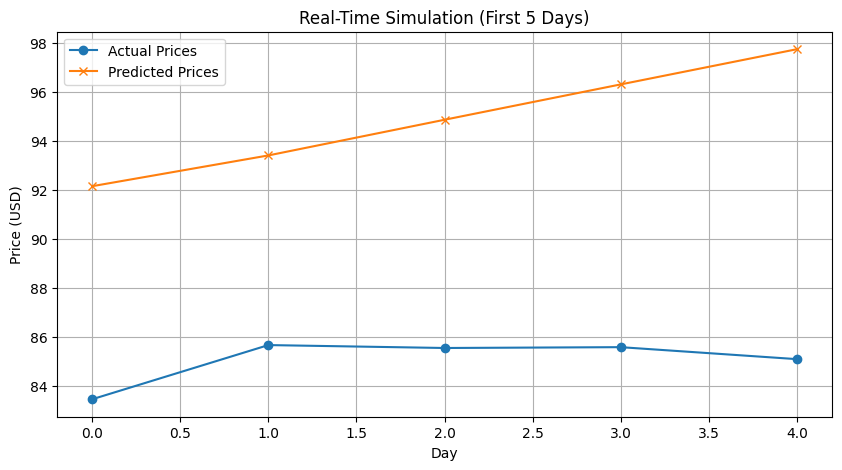

In [3]:
# Import necessary libraries
import yfinance as yf               # For fetching stock price data
import numpy as np                  # For numerical operations
import pandas as pd                 # For data manipulation
import torch                        # PyTorch for building the LSTM model
import torch.nn as nn               # Neural network module in PyTorch
import matplotlib.pyplot as plt     # For plotting charts
import seaborn as sns               # For enhanced visualizations
from sklearn.preprocessing import MinMaxScaler  # For data normalization
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For evaluation metrics

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Detect device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# --- Step 1: Data Collection ---
# Fetch historical stock prices for Apple (AAPL) from Yahoo Finance
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
# Use only the closing prices and reshape for processing
data = data['Close'].values.reshape(-1, 1)

# --- Step 2: Data Preprocessing ---
# Normalize the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Function to create sequences for LSTM input
def create_sequences(data, seq_length):
    """
    Creates sequences of length seq_length from the data for time series prediction.
    Each sequence predicts the next value.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Sequence of past seq_length days
        y.append(data[i + seq_length])    # Next day's value
    return np.array(X), np.array(y)

# Define sequence length (e.g., use 60 days to predict the next day)
seq_length = 60
X, y = create_sequences(data_normalized, seq_length)

# Split data into training (80%) and testing (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors and move to the appropriate device
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

# --- Step 3: Define the LSTM Model ---
class LSTMModel(nn.Module):
    """
    Defines an LSTM model for time series forecasting.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Pass input through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Take the output from the last time step and pass through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = 1    # Number of features (closing price)
hidden_size = 50  # Number of units in the LSTM layer
num_layers = 1    # Number of LSTM layers
output_size = 1   # Predicting one value (next day's price)

# Instantiate the model and move it to the device
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# --- Step 4: Model Training ---
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Train the model
num_epochs = 100
train_losses = []  # To store training losses for plotting
for epoch in range(num_epochs):
    model.train()
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Store loss
    train_losses.append(loss.item())
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'lstm_model.pth')

# --- Step 5: Model Evaluation ---
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss (MSE): {test_loss.item():.4f}')

# Move predictions and actual values to CPU and convert to numpy
y_pred = y_pred.cpu().numpy()
y_test = y_test.cpu().numpy()

# Inverse transform to get actual stock prices
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate additional performance metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
# Direction accuracy: whether the predicted price change direction matches the actual
actual_changes = y_test_actual[1:] - y_test_actual[:-1]
predicted_changes = y_pred_actual[1:] - y_test_actual[:-1]
direction_accuracy = np.mean(np.sign(actual_changes) == np.sign(predicted_changes))

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'Direction Accuracy: {direction_accuracy:.2f}')

# --- Step 6: Real-Time Simulation ---
# Simulate real-time prediction using the test set
# Start with the last sequence from training data
current_seq = X_train[-1].unsqueeze(0).to(device)
real_time_preds = []
real_time_actuals = []

print("\nSimulating real-time predictions (first 5 for brevity):")
for i in range(min(5, len(X_test))):  # Limit to 5 for demonstration
    with torch.no_grad():
        pred = model(current_seq)
        pred_actual = scaler.inverse_transform(pred.cpu().numpy())
        actual = y_test_actual[i]
        real_time_preds.append(pred_actual[0][0])
        real_time_actuals.append(actual[0])
        print(f'Day {i + 1} - Predicted: {pred_actual[0][0]:.2f}, Actual: {actual[0]:.2f}')
        # Update sequence with the actual value (in practice, this would be the latest data)
        new_value = torch.FloatTensor(scaler.transform(actual.reshape(-1, 1))).to(device)
        current_seq = torch.cat((current_seq[:, 1:, :], new_value.unsqueeze(0)), dim=1)

# --- Step 7: Visualization ---
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# Plot actual vs predicted prices
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('predictions.png')
plt.show()

# Plot real-time simulation (first 5 days)
plt.figure(figsize=(10, 5))
plt.plot(real_time_actuals, label='Actual Prices', marker='o')
plt.plot(real_time_preds, label='Predicted Prices', marker='x')
plt.title('Real-Time Simulation (First 5 Days)')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('realtime_simulation.png')
plt.show()

# **Option 1**: Train and Save the Model and Scaler
If you want to train an LSTM model on historical stock data (e.g., AAPL) and save the resulting model and scaler files, you can use the following Python script.

In [4]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

# Fetch historical stock prices for AAPL
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
data = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Save the scaler
scaler_path = 'models/AAPL_scaler.pkl'
os.makedirs('models', exist_ok=True)  # Create models directory if it doesn't exist
joblib.dump(scaler, scaler_path)

# Create sequences for LSTM input
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data_normalized, seq_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model
model_path = 'models/AAPL_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.0085
Epoch [20/100], Loss: 0.0088
Epoch [30/100], Loss: 0.0076
Epoch [40/100], Loss: 0.0070
Epoch [50/100], Loss: 0.0062
Epoch [60/100], Loss: 0.0048
Epoch [70/100], Loss: 0.0018
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0001
Model saved to models/AAPL_model.pth
Scaler saved to models/AAPL_scaler.pkl


# AMZN stock

In [1]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

# Fetch historical stock prices for AMZN
data = yf.download('AMZN', start='2010-01-01', end='2023-01-01')
data = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Save the scaler
scaler_path = 'models/AMZN_scaler.pkl'
os.makedirs('models', exist_ok=True)  # Create models directory if it doesn't exist
joblib.dump(scaler, scaler_path)

# Create sequences for LSTM input
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data_normalized, seq_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model
model_path = 'models/AMZN_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.0293
Epoch [20/100], Loss: 0.0262
Epoch [30/100], Loss: 0.0210
Epoch [40/100], Loss: 0.0112
Epoch [50/100], Loss: 0.0023
Epoch [60/100], Loss: 0.0014
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0002
Model saved to models/AMZN_model.pth
Scaler saved to models/AMZN_scaler.pkl


for AAPL stock pre_training

In [ ]:
import requests
import os

# Define the URLs for the pre-trained model and scaler (replace with actual URLs)
model_url = 'https://example.com/models/AAPL_model.pth'
scaler_url = 'https://example.com/models/AAPL_scaler.pkl'

# Define the local paths to save the files
model_path = 'models/AAPL_model.pth'
scaler_path = 'models/AAPL_scaler.pkl'

# Create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Download the model
print(f"Downloading model from {model_url}...")
response = requests.get(model_url)
if response.status_code == 200:
    with open(model_path, 'wb') as f:
        f.write(response.content)
    print(f"Model saved to {model_path}")
else:
    print(f"Failed to download model: {response.status_code}")

# Download the scaler
print(f"Downloading scaler from {scaler_url}...")
response = requests.get(scaler_url)
if response.status_code == 200:
    with open(scaler_path, 'wb') as f:
        f.write(response.content)
    print(f"Scaler saved to {scaler_path}")
else:
    print(f"Failed to download scaler: {response.status_code}")